In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from collections import Counter


# Data

In [ ]:
data_dir = "../data"
image_size = (100, 66)
batch_size = 32

file_paths = []
labels = []
class_names = os.listdir(data_dir)
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = f"{data_dir}/{class_name}"
    for img_path in os.listdir(class_dir):
        file_paths.append(class_dir + "/" + str(img_path))
        labels.append(class_to_index[class_name])

file_paths = np.array(file_paths)
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

# pass thru tf to convert paths to images
def preprocess_image(file_path, label):
    # final_path_file = data_dir+"/"+file_path
    img = tf.io.read_file(file_path)
    # rgb, later we normalize
    img = tf.image.decode_image(img, channels=3)
    # todo: make it optional passing to grayscale
    img = tf.image.rgb_to_grayscale(img)
    img.set_shape([None, None, 1])
    img = tf.image.resize(img, image_size)
    return img, tf.one_hot(label, depth=len(class_names))

train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_set = val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [147]:
def count_label_distribution(dset):
    label_array = [x[1] for x in dset]
    
    labels_in_dset = []
    for x in label_array:
        labels_in_dset.extend(np.argmax(x, axis = 1))
    
    return len(labels_in_dset), Counter(labels_in_dset)
    

In [148]:
total_train, train_label_count = count_label_distribution(train_set)
total_val, val_label_count = count_label_distribution(val_set)
total_test, test_label_count = count_label_distribution(test_set)

In [149]:
train_label_count,val_label_count, test_label_count

(Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 75, np.int64(1): 73, np.int64(0): 71}),
 Counter({np.int64(2): 75, np.int64(0): 72, np.int64(1): 72}))

In [150]:
sum([total_train, total_val, total_test])

2188

In [151]:
len(file_paths)

2188

# Model

## Data Augmentation

In [152]:
# vertical here should only make sense since images are right-oriented
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

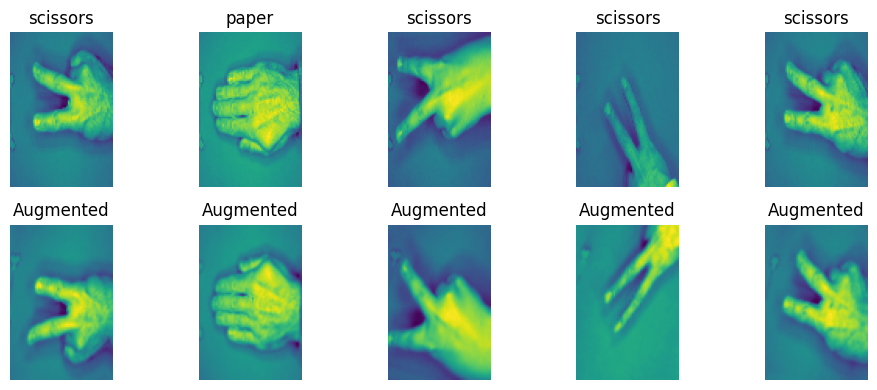

In [ ]:
for images, label in train_set.take(1):
    augmented_images = data_augmentation(images)

    num_images = 5
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

        # aug
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

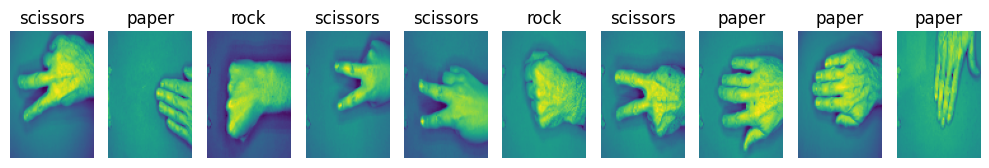

In [154]:
for images, label in val_set.take(1):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

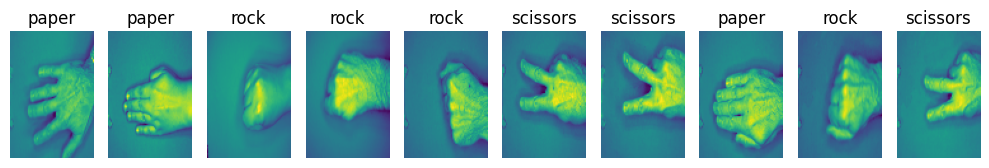

In [155]:
for images, label in test_set.take(1):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

## First

In [156]:
which_model = "first_architecture"

def root_logdir(architecture_name):
    return os.path.join(os.curdir, "logs\\"+architecture_name)

def get_run_logdir(architecture_name):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir(architecture_name), run_id)

In [161]:
get_run_logdir("first_architecture")

'.\\logs\\first_architecture\\run_2025_07_06-17_51_36'

In [164]:
normalization_layer = Rescaling(1./255)

model = Sequential([
    Input(shape = (image_size[0], image_size[1], 1)),
    normalization_layer,
    data_augmentation,
    Conv2D(64, 7, activation = "relu", padding = "same"),
    MaxPooling2D(2),
    Conv2D(64, 3, activation = "relu", padding = "same"),
    MaxPooling2D(2),
    Flatten(),
    Dense(64),
    Dense(3, activation = "softmax")
])

model.compile(loss = "categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

In [166]:
run_logdir = get_run_logdir("first_architecture")
tensorboard_cb = TensorBoard(run_logdir)
best_model_checkpoint = ModelCheckpoint(run_logdir+ "/first_model.keras", save_best_only=True)

history = model.fit(train_set, validation_data=val_set, epochs=10, callbacks=[best_model_checkpoint,tensorboard_cb])

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3323 - loss: 1.1110 - val_accuracy: 0.3288 - val_loss: 1.0794
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4133 - loss: 1.0724 - val_accuracy: 0.4749 - val_loss: 1.0654
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.4808 - loss: 1.0431 - val_accuracy: 0.4886 - val_loss: 1.0154
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5606 - loss: 0.9779 - val_accuracy: 0.6530 - val_loss: 0.9574
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6167 - loss: 0.9274 - val_accuracy: 0.5023 - val_loss: 0.9449
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.6587 - loss: 0.8571 - val_accuracy: 0.7260 - val_loss: 0.8495
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6994 - loss: 0.8142 - val_accuracy: 0.7169 - val_loss: 0.8044
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.7250 - loss: 0.7658 - val_accuracy: 0.7123 - v

In [113]:
# %load_ext tensorboard
# %tensorboard --logdir=./my_logs --port=6006

In [168]:
model.evaluate(test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8016 - loss: 0.5507


[0.5847322940826416, 0.7899543642997742]

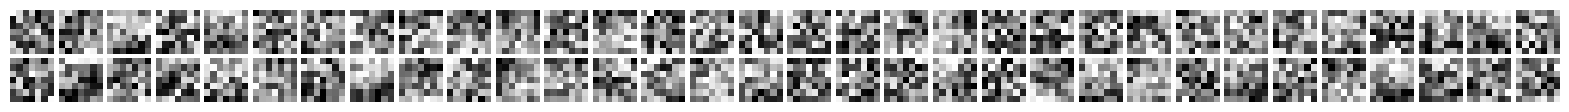

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

filters, biases = model.layers[2].get_weights()

# normalize
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = filters.shape[3]
grid_size = 32
fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

for i in range(grid_size * grid_size):
    ax = axs[i // grid_size, i % grid_size]
    ax.axis('off')
    
    if i < n_filters:
        f = filters[:, :, :, i]
        if f.shape[2] == 3:  # if rgb
            ax.imshow(f)
        else:  # grayscale
            ax.imshow(f[:, :, 0], cmap='gray')
    else:
        ax.set_visible(False)

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


In [130]:
model.layers

[<Rescaling name=rescaling_1, built=True>,
 <Sequential name=sequential_4, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <MaxPooling2D name=max_pooling2d_2, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <MaxPooling2D name=max_pooling2d_3, built=True>,
 <Flatten name=flatten_1, built=True>,
 <Dense name=dense_2, built=True>,
 <Dense name=dense_3, built=True>]

In [163]:
predictions = model.predict(test_set)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Second

## Third